<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

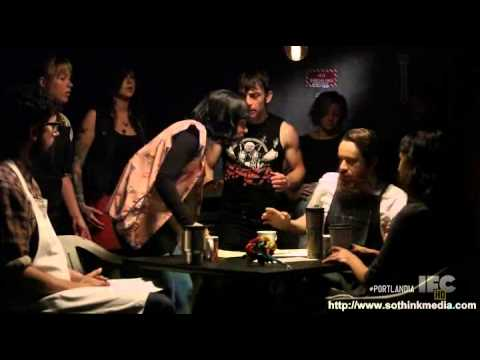

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/home/ekram49/workspace/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [5]:
shops['coffee_shop_name'][0]

'The Factory - Cafe With a Soul '

In [6]:
shops['full_review_text'][0]

' 11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? '

In [7]:
shops['star_rating'][0]

' 5.0 star rating '

In [ ]:
# Removing whitespace

In [9]:
shops['coffee_shop_name'] = shops['coffee_shop_name'].str.strip()

In [10]:
shops['full_review_text'] = shops['full_review_text'].str.strip()

In [ ]:
shops['full_review_text'] = shops['full_review_text'].str.strip()

In [11]:
shops['star_rating'] = shops['star_rating'].str.strip()

In [12]:
shops['coffee_shop_name'][0]

'The Factory - Cafe With a Soul'

In [13]:
shops['full_review_text'][0]

'11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas?'

In [14]:
shops['star_rating'][0]

'5.0 star rating'

In [26]:
# Gonna seperate the dataframe into good and bad shops
# Best shops(shops_b) = star rating 4.0 or 5.0
shops_b = shops[(shops['star_rating'] == '5.0 star rating') | (shops['star_rating'] == '4.0 star rating')]
shops_b.head()

,coffee_shop_name,full_review_text,star_rating,dates
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atmo...,5.0 star rating,11/25/2016 1 check-in Love love loved the atmo...
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambian...",4.0 star rating,"12/2/2016 Listed in Date Night: Austin, Ambian..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots I...,4.0 star rating,11/30/2016 1 check-in Listed in Brunch Spots I...
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within t...,4.0 star rating,12/3/2016 1 check-in They are located within t...
5,The Factory - Cafe With a Soul,11/20/2016 1 check-in Very cute cafe! I think ...,4.0 star rating,11/20/2016 1 check-in Very cute cafe! I think ...


In [27]:
# Worst shops(shops_w) = star rating 3.0 or 2.0, or 1.0
shops_w = shops[(shops['star_rating'] == '3.0 star rating') | (shops['star_rating'] == '2.0 star rating') | (shops['star_rating'] == '1.0 star rating')]
shops_w.head()

,coffee_shop_name,full_review_text,star_rating,dates
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice s...,2.0 star rating,11/25/2016 Very cool decor! Good drinks Nice s...
8,The Factory - Cafe With a Soul,"10/25/2016 1 check-in Ok, let's try this appro...",3.0 star rating,"10/25/2016 1 check-in Ok, let's try this appro..."
11,The Factory - Cafe With a Soul,"11/20/2016 The store has A+ decoration, but ho...",3.0 star rating,NaN
12,The Factory - Cafe With a Soul,11/17/2016 1 check-in Listed in 2016 - The Thi...,3.0 star rating,NaN
25,The Factory - Cafe With a Soul,"12/2/2016 Okay, so after visiting my friends i...",1.0 star rating,NaN


In [28]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [71]:
STOP_WORDS = nlp.Defaults.stop_words.union(['batteries','I', 'amazon', 'i', 'Amazon', 'it', "it's", 'it.', 'the', 'this', ' ', '-', '1', "i've", "i'm", 'place', 'coffee', "don't"])

In [63]:
# Tokenizer Pipe

tokens_b = []

""" Make them tokens """
for doc in tokenizer.pipe(shops_b['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens_b.append(doc_tokens)

shops_b['tokens_b'] = tokens_b

tokens_b = []


/home/ekram49/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [64]:

""" Update those tokens with stopwords"""
for doc in tokenizer.pipe(shops_b['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())

    tokens_b.append(doc_tokens)

shops_b['tokens_b'] = tokens_b

/home/ekram49/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [42]:
shops_b.tail()

,coffee_shop_name,full_review_text,star_rating,dates,tokens_b
7610,The Steeping Room,3/1/2016 Great food! I haven't had a meal I di...,5.0 star rating,NaN,"[3/1/2016, great, food!, haven't, meal, enjoy,..."
7611,The Steeping Room,2/19/2015 I actually step into this restaurant...,4.0 star rating,NaN,"[2/19/2015, actually, step, restaurant, chance..."
7612,The Steeping Room,"1/21/2016 Ok, The Steeping Room IS awesome. Ho...",5.0 star rating,NaN,"[1/21/2016, ok,, steeping, room, awesome., gre..."
7613,The Steeping Room,"4/30/2015 Loved coming here for tea, and the a...",4.0 star rating,NaN,"[4/30/2015, loved, coming, tea,, atmosphere, p..."
7615,The Steeping Room,5/23/2015 I finally stopped in for lunch with ...,4.0 star rating,NaN,"[5/23/2015, finally, stopped, lunch, colleague..."


In [46]:
# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [65]:
wcb = count(shops_b['tokens_b'])
wcb.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
12,coffee,3383,6421,1.0,0.021036,0.021036,0.550977
114,place,2432,3389,2.0,0.011103,0.032139,0.396091
137,great,2174,2902,3.0,0.009507,0.041646,0.354072
344,good,1643,2180,4.0,0.007142,0.048788,0.267590
246,like,1486,2068,5.0,0.006775,0.055563,0.242020


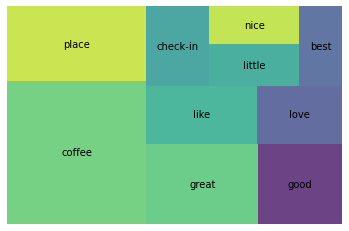

In [66]:
import squarify
import matplotlib.pyplot as plt
wcb = count(shops_b['tokens_b'])

wcb_top10 = wcb[wcb['rank'] <= 10]

squarify.plot(sizes=wcb_top10['pct_total'], label=wcb_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [72]:
# Tokenizer Pipe

tokens_w = []

""" Make them tokens """
for doc in tokenizer.pipe(shops_w['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens_w.append(doc_tokens)

shops_w['tokens_w'] = tokens_w

tokens_w = []

/home/ekram49/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [73]:
""" Update those tokens with stopwords"""
for doc in tokenizer.pipe(shops_w['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())

    tokens_w.append(doc_tokens)

shops_w['tokens_w'] = tokens_w

/home/ekram49/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [74]:
wcw = count(shops_w['tokens_w'])
wcw.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
23,like,548,834,1.0,0.009967,0.009967,0.371274
6,good,441,599,2.0,0.007159,0.017126,0.298780
185,food,266,369,3.0,0.004410,0.021535,0.180217
93,check-in,359,359,4.0,0.004290,0.025826,0.243225
219,time,264,351,5.0,0.004195,0.030021,0.178862


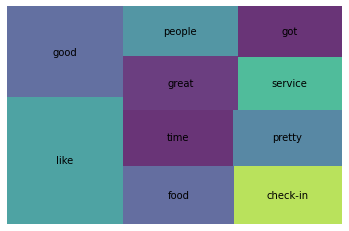

In [75]:
wcw = count(shops_w['tokens_w'])

wcw_top10 = wcw[wcw['rank'] <= 10]

squarify.plot(sizes=wcw_top10['pct_total'], label=wcw_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

